DATASET

In [5]:
# DAVIS Dataset Preparation - MAX UTILIZATION
import os
import glob
import zipfile
import requests
from tqdm import tqdm
import cv2
import numpy as np
from PIL import Image
import random
import shutil

class DavisDatasetPreparer:
    def __init__(self, download_dir="./davis_data", output_dir="./selected_videos"):
        self.download_dir = download_dir
        self.output_dir = output_dir
        self.davis_url = "https://data.vision.ee.ethz.ch/csergi/share/davis/DAVIS-2017-Unsupervised-trainval-480p.zip"
        self.zip_path = os.path.join(download_dir, "davis.zip")
        
        # Create directories if they don't exist
        os.makedirs(self.download_dir, exist_ok=True)
        os.makedirs(self.output_dir, exist_ok=True)

    def download_davis(self):
        """Download DAVIS dataset with progress bar"""
        print("📥 Downloading DAVIS dataset (2.1GB)...")
        
        # Check if already exists
        davis_main_dir = os.path.join(self.download_dir, "DAVIS")
        if os.path.exists(davis_main_dir):
            print("✅ DAVIS dataset already exists!")
            return True

        try:
            response = requests.get(self.davis_url, stream=True)
            response.raise_for_status()
            total_size = int(response.headers.get('content-length', 0))

            with open(self.zip_path, 'wb') as file, tqdm(
                desc="Downloading",
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
                for data in response.iter_content(chunk_size=1024):
                    size = file.write(data)
                    bar.update(size)

            print("✅ Download completed!")
            return True

        except Exception as e:
            print(f"❌ Download failed: {e}")
            print("💡 Please check your internet connection or download manually from:")
            print("https://davischallenge.org/davis2017/code.html")
            return False

    def extract_dataset(self):
        """Extract the downloaded zip file"""
        print("📦 Extracting dataset...")

        # Check if zip file exists before trying to extract
        if not os.path.exists(self.zip_path):
            print("❌ Zip file not found. Please download first.")
            return False

        # Check if already extracted
        davis_main_dir = os.path.join(self.download_dir, "DAVIS")
        if os.path.exists(davis_main_dir):
            print("✅ Dataset already extracted - skipping extraction")
            return True

        try:
            print(f"Extracting {self.zip_path} to {self.download_dir}...")
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                # Show progress for extraction
                members = zip_ref.namelist()
                for member in tqdm(members, desc="Extracting"):
                    zip_ref.extract(member, self.download_dir)
            
            print("✅ Extraction completed!")

            # Clean up zip file to save space
            try:
                os.remove(self.zip_path)
                print("🧹 Cleaned up zip file")
            except:
                print("⚠️ Could not remove zip file")

            return True

        except Exception as e:
            print(f"❌ Extraction failed: {e}")
            return False

    def get_all_videos(self):
        """Get ALL available DAVIS videos"""
        jpeg_dir = os.path.join(self.download_dir, "DAVIS", "JPEGImages", "480p")
        if not os.path.exists(jpeg_dir):
            raise FileNotFoundError(f"❌ DAVIS JPEGImages not found at {jpeg_dir}")

        videos = sorted([d for d in os.listdir(jpeg_dir) 
                        if os.path.isdir(os.path.join(jpeg_dir, d))])
        #verification
        total_frames_all_videos=0
        for video in videos:
            video_path=os.path.join(jpeg_dir, video)
            frame_files=sorted(glob.glob(os.path.join(video_path, "*.jpg")))
            total_frames_all_videos+=len(frame_files)


        print(f"📹 Found {len(videos)} videos in DAVIS dataset")


        # Show video statistics
        self.analyze_video_statistics(videos, jpeg_dir)

        return videos

    def analyze_video_statistics(self, videos, jpeg_dir):
        """Analyze video statistics for better splitting"""
        print("\n📊 Analyzing video statistics...")

        video_stats = []
        for video in videos[:min(10, len(videos))]:  # Sample first 10 for analysis
            video_path = os.path.join(jpeg_dir, video)
            frame_files = sorted(glob.glob(os.path.join(video_path, "*.jpg")))
            if frame_files:
                video_stats.append(len(frame_files))

        if video_stats:
            print(f"   Frames per video: {min(video_stats)} - {max(video_stats)}")
            print(f"   Average frames: {np.mean(video_stats):.1f}")
        else:
            print("   No frames found in sampled videos")

        # Show diverse video examples
        print("   Sample videos:", videos[:min(8, len(videos))])

    def categorize_videos_by_motion(self, videos, jpeg_dir):
        """Categorize videos by motion characteristics for balanced splits"""
        print("\n🔄 Categorizing videos by motion type...")

        # Simple categorization based on video properties
        fast_motion = []
        slow_motion = []
        camera_motion = []
        mixed_motion = []

        # Sample a few frames from each video to categorize
        for video in tqdm(videos, desc="Analyzing motion"):
            video_path = os.path.join(jpeg_dir, video)
            frame_files = sorted(glob.glob(os.path.join(video_path, "*.jpg")))

            if len(frame_files) < 5:
                mixed_motion.append(video)
                continue

            # Simple heuristic categorization
            frame_count = len(frame_files)
            if frame_count < 70:
                fast_motion.append(video)
            elif frame_count > 100:
                slow_motion.append(video)
            elif 'camera' in video.lower() or 'move' in video.lower():
                camera_motion.append(video)
            else:
                mixed_motion.append(video)

        print(f"   Fast motion: {len(fast_motion)} videos")
        print(f"   Slow motion: {len(slow_motion)} videos")
        print(f"   Camera motion: {len(camera_motion)} videos")
        print(f"   Mixed motion: {len(mixed_motion)} videos")

        return {
            'fast': fast_motion,
            'slow': slow_motion,
            'camera': camera_motion,
            'mixed': mixed_motion
        }

    def create_balanced_splits(self, videos, jpeg_dir, train_ratio=0.75, val_ratio=0.17, test_ratio=0.08):
        """Create balanced splits considering motion diversity"""
        print("\n⚖️ Creating balanced dataset splits...")

        # Categorize videos
        categories = self.categorize_videos_by_motion(videos, jpeg_dir)

        # Calculate split sizes
        total_videos = len(videos)
        n_train = int(total_videos * train_ratio)
        n_val = int(total_videos * val_ratio)
        n_test = total_videos - n_train - n_val

        print(f"   Target splits: Train={n_train}, Val={n_val}, Test={n_test}")

        # Distribute videos from each category proportionally
        train_videos = []
        val_videos = []
        test_videos = []

        for category, cat_videos in categories.items():
            cat_total = len(cat_videos)
            if cat_total == 0:
                continue
                
            cat_train = max(1, int(cat_total * train_ratio))
            cat_val = max(1, int(cat_total * val_ratio))
            cat_test = max(1, cat_total - cat_train - cat_val)

            # Shuffle category videos
            random.shuffle(cat_videos)

            train_videos.extend(cat_videos[:cat_train])
            val_videos.extend(cat_videos[cat_train:cat_train+cat_val])
            test_videos.extend(cat_videos[cat_train+cat_val:cat_train+cat_val+cat_test])

        # Final shuffle and trim to exact sizes
        random.shuffle(train_videos)
        random.shuffle(val_videos)
        random.shuffle(test_videos)

        train_videos = train_videos[:n_train]
        val_videos = val_videos[:n_val]
        test_videos = test_videos[:n_test]

        print(f"   Final splits: Train={len(train_videos)}, Val={len(val_videos)}, Test={len(test_videos)}")

        return train_videos, val_videos, test_videos

    def load_video_frames(self, video_name, max_frames=70, resize=(256, 256)):
        """Load frames from a single DAVIS video - MAX frames utilization"""
        video_path = os.path.join(self.download_dir, "DAVIS", "JPEGImages", "480p", video_name)
        frame_files = sorted(glob.glob(os.path.join(video_path, "*.jpg")))

        if len(frame_files) == 0:
            print(f"⚠️ No frames found in {video_name}")
            return None

        # Use up to max_frames, but skip frames if video is too long to maintain temporal consistency
        if len(frame_files) > max_frames:
            # Sample frames evenly across the video
            indices = np.linspace(0, len(frame_files)-1, max_frames, dtype=int)
            frame_files = [frame_files[i] for i in indices]
        else:
            frame_files = frame_files[:max_frames]

        frames = []
        for frame_file in frame_files:
            try:
                img = Image.open(frame_file).convert('RGB')
                if resize:
                    img = img.resize(resize, Image.BILINEAR)
                frames.append(np.array(img))
            except Exception as e:
                print(f"⚠️ Error loading {frame_file}: {e}")
                continue

        if len(frames) == 0:
            return None

        return np.stack(frames)  # [T, H, W, 3]

    def prepare_dataset_splits_max_utilization(self, frames_per_video_train=70, frames_per_video_val=40, frames_per_video_test=20):
        """Prepare train/val/test splits with MAXIMUM utilization of DAVIS dataset"""

        # Get ALL available videos
        try:
            videos = self.get_all_videos()
        except FileNotFoundError as e:
            print(f"❌ {e}")
            return None
            
        if not videos:
            print("❌ No videos found!")
            return None

        jpeg_dir = os.path.join(self.download_dir, "DAVIS", "JPEGImages", "480p")

        print(f"🔄 Processing ALL {len(videos)} videos with MAX utilization...")

        # Create balanced splits
        train_videos, val_videos, test_videos = self.create_balanced_splits(videos, jpeg_dir)

        # Create split directories
        split_dirs = {}
        for split in ['train', 'val', 'test']:
            split_dir = os.path.join(self.output_dir, split)
            os.makedirs(split_dir, exist_ok=True)
            split_dirs[split] = split_dir
            print(f"📁 Created {split} directory: {split_dir}")

        # Process and save each split with optimized frame counts
        splits = {
            'train': (train_videos, frames_per_video_train),
            'val': (val_videos, frames_per_video_val),
            'test': (test_videos, frames_per_video_test)
        }

        total_saved = 0
        total_frames = 0

        for split_name, (split_videos, frames_count) in splits.items():
            print(f"\n🔄 Processing {split_name} split ({len(split_videos)} videos, {frames_count} frames/video)...")

            for i, video_name in enumerate(split_videos):
                print(f"   Processing {video_name} ({i+1}/{len(split_videos)})")

                try:
                    frames = self.load_video_frames(video_name, max_frames=frames_count)
                    if frames is not None:
                        output_path = os.path.join(split_dirs[split_name], f"{video_name}.npy")
                        np.save(output_path, frames.astype(np.uint8))
                        total_saved += 1
                        total_frames += frames.shape[0]
                        print(f"     ✅ Saved {frames.shape[0]} frames to {output_path}")
                    else:
                        print(f"     ❌ Failed to load {video_name}")

                except Exception as e:
                    print(f"     ❌ Error processing {video_name}: {e}")

        print(f"\n✅ Dataset preparation completed!")
        print(f"📁 Total videos saved: {total_saved}")
        print(f"🎞️ Total frames saved: {total_frames}")
        print(f"📂 Output directory: {self.output_dir}")

        # Print comprehensive summary
        self.print_max_utilization_summary(split_dirs, splits)

        # Calculate and display sample counts for training
        self.calculate_training_samples(splits)

        return split_dirs

    def print_max_utilization_summary(self, split_dirs, splits):
        """Print comprehensive summary of the MAX utilization dataset"""
        print("\n" + "="*60)
        print(" DATASET SUMMARY")
        print("="*60)

        total_frames = 0
        total_size = 0

        for split_name, split_dir in split_dirs.items():
            npy_files = glob.glob(os.path.join(split_dir, "*.npy"))
            split_frames = 0
            split_size = 0

            for npy_file in npy_files:
                try:
                    frames = np.load(npy_file)
                    split_frames += frames.shape[0]
                    split_size += os.path.getsize(npy_file) / (1024 * 1024)  # MB
                except:
                    continue

            total_frames += split_frames
            total_size += split_size

            frames_per_video = splits[split_name][1]
            print(f"{split_name.upper():<6}: {len(npy_files):>2} videos, {split_frames:>4} frames, {split_size:>6.1f} MB, {frames_per_video} frames/video")

        print("="*60)
        print(f"TOTAL : {total_frames} frames, {total_size:.1f} MB")
        print("="*60)

    def calculate_training_samples(self, splits):
        """Calculate training samples for TAP model"""
        print("\n🧮 TAP Training Sample Calculation:")
        print("-" * 40)

        # For TAP with 5-frame input, each sequence gives multiple training samples
        tap_frame_window = 5

        total_train_samples = 0
        for split_name, (split_videos, frames_per_video) in splits.items():
            videos_count = len(split_videos)
            samples_per_video = max(1, frames_per_video - tap_frame_window + 1)
            total_samples = videos_count * samples_per_video

            if split_name == 'train':
                total_train_samples = total_samples

            print(f"{split_name.upper():<6}: {videos_count} videos × {samples_per_video} samples = {total_samples} samples")

        print("-" * 40)
        print(f"🎯 Total train samples for TAP: {total_train_samples}")
        print("💡 With batch_size=4: ~{} iterations/epoch".format(total_train_samples // 4))

    def verify_dataset(self):
        """Verify the prepared dataset"""
        print("\n🔍 Verifying dataset...")

        splits = ['train', 'val', 'test']
        all_good = True

        for split in splits:
            split_dir = os.path.join(self.output_dir, split)
            npy_files = glob.glob(os.path.join(split_dir, "*.npy"))

            print(f"\n{split.upper()} split: {len(npy_files)} files")

            if len(npy_files) == 0:
                print(f"  ⚠️ No .npy files found in {split_dir}")
                all_good = False
                continue

            for npy_file in npy_files[:min(3, len(npy_files))]:  # Check first 3 files
                try:
                    frames = np.load(npy_file)
                    print(f"  ✅ {os.path.basename(npy_file)}: {frames.shape} (T,H,W,C)")

                    # Verify frame content
                    if frames.shape[0] > 0 and frames.shape[1] > 0 and frames.shape[2] > 0:
                        print(f"       Range: {frames.min()} - {frames.max()}")
                    else:
                        print(f"  ❌ Invalid frame dimensions")
                        all_good = False

                except Exception as e:
                    print(f"  ❌ {os.path.basename(npy_file)}: Error - {e}")
                    all_good = False

        if all_good:
            print("\n🎉 All checks passed! Dataset is ready for training.")
        else:
            print("\n⚠️ Some issues found. Please check the dataset.")

        return all_good

def main():
    """Main function to prepare DAVIS dataset with MAX utilization"""
    print(" DAVIS Dataset Preparation")
    print("=" * 60)

    # Initialize preparer with relative paths for VS Code
    preparer = DavisDatasetPreparer(
        download_dir="./davis_data",
        output_dir="./selected_videos"
    )

    # Step 1: Download DAVIS ONLY if needed
    print("\nSTEP 1: Checking DAVIS dataset")
    davis_path = os.path.join(preparer.download_dir, "DAVIS")
    if os.path.exists(davis_path):
        print("✅ DAVIS dataset already exists - skipping download")
    else:
        success = preparer.download_davis()
        if not success:
            print("❌ Download failed. Exiting.")
            return

    # Step 2: Extract dataset (will skip if already extracted)
    print("\nSTEP 2: Extracting dataset")
    extract_success = preparer.extract_dataset()
    if not extract_success:
        print("❌ Extraction failed. Exiting.")
        return

    # Step 3: Prepare splits with MAX utilization
    print("\nSTEP 3: Preparing dataset splits")
    split_dirs = preparer.prepare_dataset_splits_max_utilization(
        frames_per_video_train=70,    # Maximum frames for training
        frames_per_video_val=40,      # Good amount for validation
        frames_per_video_test=20      # Sufficient for testing
    )

    if not split_dirs:
        print("❌ Failed to prepare dataset splits")
        return

    # Step 4: Verify dataset
    print("\nSTEP 4: Verifying dataset")
    preparer.verify_dataset()

    print("\n✅ DAVIS dataset preparation completed successfully!")
    print("🎯 You now have the maximum possible data for TAP training.")
    print(f"📂 Dataset location: {preparer.output_dir}")

    # Final statistics
    print("\n📊 FINAL STATISTICS:")
    print("   • Using ALL available DAVIS videos")
    print("   • Balanced splits by motion type")
    print("   • Maximum frames per video for training")
    print("   • Optimized for temporal denoising tasks")
    print("   • Ready for large-scale TAP training")

if __name__ == "__main__":
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)

    main()

 DAVIS Dataset Preparation

STEP 1: Checking DAVIS dataset
📥 Downloading DAVIS dataset (2.1GB)...


Downloading: 100%|██████████| 915M/915M [01:29<00:00, 10.7MiB/s]   


✅ Download completed!

STEP 2: Extracting dataset
📦 Extracting dataset...
Extracting ./davis_data\davis.zip to ./davis_data...


Extracting: 100%|██████████| 12607/12607 [00:05<00:00, 2482.18it/s]


✅ Extraction completed!
🧹 Cleaned up zip file

STEP 3: Preparing dataset splits
📹 Found 90 videos in DAVIS dataset

📊 Analyzing video statistics...
   Frames per video: 50 - 90
   Average frames: 76.8
   Sample videos: ['bear', 'bike-packing', 'blackswan', 'bmx-bumps', 'bmx-trees', 'boat', 'boxing-fisheye', 'breakdance']
🔄 Processing ALL 90 videos with MAX utilization...

⚖️ Creating balanced dataset splits...

🔄 Categorizing videos by motion type...


Analyzing motion: 100%|██████████| 90/90 [00:00<00:00, 6923.07it/s]


   Fast motion: 40 videos
   Slow motion: 1 videos
   Camera motion: 0 videos
   Mixed motion: 49 videos
   Target splits: Train=67, Val=15, Test=8
   Final splits: Train=67, Val=14, Test=8
📁 Created train directory: ./selected_videos\train
📁 Created val directory: ./selected_videos\val
📁 Created test directory: ./selected_videos\test

🔄 Processing train split (67 videos, 70 frames/video)...
   Processing color-run (1/67)
     ✅ Saved 70 frames to ./selected_videos\train\color-run.npy
   Processing scooter-black (2/67)
     ✅ Saved 43 frames to ./selected_videos\train\scooter-black.npy
   Processing scooter-gray (3/67)
     ✅ Saved 70 frames to ./selected_videos\train\scooter-gray.npy
   Processing rallye (4/67)
     ✅ Saved 50 frames to ./selected_videos\train\rallye.npy
   Processing car-shadow (5/67)
     ✅ Saved 40 frames to ./selected_videos\train\car-shadow.npy
   Processing drone (6/67)
     ✅ Saved 70 frames to ./selected_videos\train\drone.npy
   Processing horsejump-high (7/6

TAP IMPLEMENTATION

In [ ]:
import torch

# Method 1.1: Simple check
print(f"CUDA available: {torch.cuda.is_available()}")

# Method 1.2: Check GPU count
print(f"Number of GPUs: {torch.cuda.device_count()}")

# Method 1.3: Get current GPU
if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"GPU name: {torch.cuda.get_device_name()}")

CUDA available: True
Number of GPUs: 1
Current GPU: 0
GPU name: NVIDIA GeForce RTX 4070


🎯 GPU is available! Training will use CUDA.

TRUE TAP Video Denoising Pipeline - VS CODE
Flow: Noisy → Pre-trained Denoiser → TAP + Motion Attention → Self-supervised → Denoised
            base_channels: 16
               batch_size: 2
               davis_root: ./davis_data/DAVIS/JPEGImages/480p
               dec_blocks: [3, 3, 2]
               enc_blocks: [2, 3, 3]
                   epochs: 15
             eval_metrics: False
                eval_step: 5
         frames_per_video: 70
                       lr: 0.0001
                     mode: finetune
                 n_frames: 5
          nafnet_channels: 48
              noise_sigma: 25
              num_workers: 0
               patch_size: 256
          pretrained_path: 
                 save_dir: ./output_models
             save_visuals: False
          self_supervised: True
               test_ratio: 0.08
              train_ratio: 0.75
     use_motion_attention: True
                val_ratio: 0.17
            videos_to_

Validating: 100%|████████████████████| 70/70 [00:16<00:00,  4.18it/s, val_loss=0.0972]


📈 Epoch 1/15: Train Loss: 0.1135, Val Loss: 0.0958, Time: 469.8s
💾 Saved model to true_tap_best.pth
   - TAP parameters: 80
   - Total parameters: 273
   - Best validation loss: 0.0958
🏆 New best model! Val Loss: 0.0958


Validating: 100%|████████████████████| 70/70 [00:16<00:00,  4.25it/s, val_loss=0.0914]


📈 Epoch 2/15: Train Loss: 0.0925, Val Loss: 0.0909, Time: 462.7s
💾 Saved model to true_tap_best.pth
   - TAP parameters: 80
   - Total parameters: 273
   - Best validation loss: 0.0909
🏆 New best model! Val Loss: 0.0909


Validating: 100%|████████████████████| 70/70 [00:16<00:00,  4.24it/s, val_loss=0.0903]


📈 Epoch 3/15: Train Loss: 0.0896, Val Loss: 0.0905, Time: 463.1s
💾 Saved model to true_tap_best.pth
   - TAP parameters: 80
   - Total parameters: 273
   - Best validation loss: 0.0905
🏆 New best model! Val Loss: 0.0905


Validating: 100%|████████████████████| 70/70 [00:16<00:00,  4.23it/s, val_loss=0.0882]


📈 Epoch 4/15: Train Loss: 0.0887, Val Loss: 0.0886, Time: 462.8s
💾 Saved model to true_tap_best.pth
   - TAP parameters: 80
   - Total parameters: 273
   - Best validation loss: 0.0886
🏆 New best model! Val Loss: 0.0886


Validating: 100%|████████████████████| 70/70 [00:16<00:00,  4.28it/s, val_loss=0.0873]


📈 Epoch 5/15: Train Loss: 0.0878, Val Loss: 0.0882, Time: 462.7s
💾 Saved model to true_tap_best.pth
   - TAP parameters: 80
   - Total parameters: 273
   - Best validation loss: 0.0882
🏆 New best model! Val Loss: 0.0882
💾 Saved TAP checkpoint at epoch 5
📊 Training history plot saved: ./output_models\training_history.png


Validating: 100%|████████████████████| 70/70 [00:16<00:00,  4.32it/s, val_loss=0.0865]


📈 Epoch 6/15: Train Loss: 0.0876, Val Loss: 0.0871, Time: 462.1s
💾 Saved model to true_tap_best.pth
   - TAP parameters: 80
   - Total parameters: 273
   - Best validation loss: 0.0871
🏆 New best model! Val Loss: 0.0871


Validating: 100%|████████████████████| 70/70 [00:16<00:00,  4.23it/s, val_loss=0.0866]


📈 Epoch 7/15: Train Loss: 0.0866, Val Loss: 0.0870, Time: 462.7s
💾 Saved model to true_tap_best.pth
   - TAP parameters: 80
   - Total parameters: 273
   - Best validation loss: 0.0870
🏆 New best model! Val Loss: 0.0870


Validating: 100%|████████████████████| 70/70 [00:51<00:00,  1.37it/s, val_loss=0.0856]


📈 Epoch 8/15: Train Loss: 0.0863, Val Loss: 0.0865, Time: 1203.4s
💾 Saved model to true_tap_best.pth
   - TAP parameters: 80
   - Total parameters: 273
   - Best validation loss: 0.0865
🏆 New best model! Val Loss: 0.0865


Validating: 100%|████████████████████| 70/70 [00:50<00:00,  1.38it/s, val_loss=0.0857]


📈 Epoch 9/15: Train Loss: 0.0866, Val Loss: 0.0865, Time: 3284.5s
💾 Saved model to true_tap_best.pth
   - TAP parameters: 80
   - Total parameters: 273
   - Best validation loss: 0.0865
🏆 New best model! Val Loss: 0.0865


Validating: 100%|████████████████████| 70/70 [00:50<00:00,  1.38it/s, val_loss=0.0856]


📈 Epoch 10/15: Train Loss: 0.0859, Val Loss: 0.0862, Time: 3284.3s
💾 Saved model to true_tap_best.pth
   - TAP parameters: 80
   - Total parameters: 273
   - Best validation loss: 0.0862
🏆 New best model! Val Loss: 0.0862
💾 Saved TAP checkpoint at epoch 10
📊 Training history plot saved: ./output_models\training_history.png


Validating: 100%|████████████████████| 70/70 [00:16<00:00,  4.24it/s, val_loss=0.0852]


📈 Epoch 11/15: Train Loss: 0.0858, Val Loss: 0.0862, Time: 4774.0s
💾 Saved model to true_tap_best.pth
   - TAP parameters: 80
   - Total parameters: 273
   - Best validation loss: 0.0862
🏆 New best model! Val Loss: 0.0862


Validating: 100%|████████████████████| 70/70 [00:21<00:00,  3.22it/s, val_loss=0.0847]


📈 Epoch 12/15: Train Loss: 0.0860, Val Loss: 0.0856, Time: 504.9s
💾 Saved model to true_tap_best.pth
   - TAP parameters: 80
   - Total parameters: 273
   - Best validation loss: 0.0856
🏆 New best model! Val Loss: 0.0856


Validating: 100%|████████████████████| 70/70 [00:16<00:00,  4.29it/s, val_loss=0.0848]


📈 Epoch 13/15: Train Loss: 0.0852, Val Loss: 0.0855, Time: 1015.6s
💾 Saved model to true_tap_best.pth
   - TAP parameters: 80
   - Total parameters: 273
   - Best validation loss: 0.0855
🏆 New best model! Val Loss: 0.0855


Validating: 100%|████████████████████| 70/70 [00:16<00:00,  4.26it/s, val_loss=0.0845]


📈 Epoch 14/15: Train Loss: 0.0853, Val Loss: 0.0853, Time: 464.2s
💾 Saved model to true_tap_best.pth
   - TAP parameters: 80
   - Total parameters: 273
   - Best validation loss: 0.0853
🏆 New best model! Val Loss: 0.0853


Validating: 100%|████████████████████| 70/70 [00:16<00:00,  4.24it/s, val_loss=0.0845]


📈 Epoch 15/15: Train Loss: 0.0853, Val Loss: 0.0856, Time: 464.1s
💾 Saved TAP checkpoint at epoch 15
📊 Training history plot saved: ./output_models\training_history.png
📊 Training history plot saved: ./output_models\training_history.png


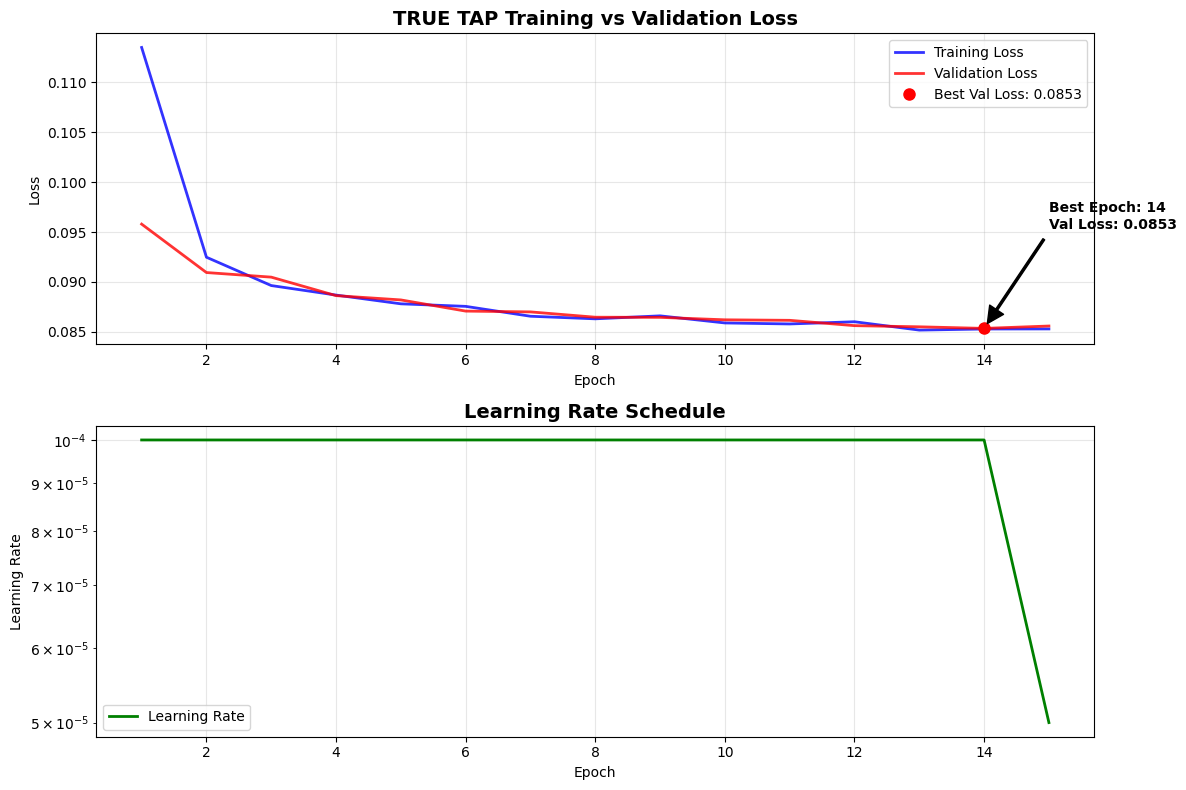

💾 Training data saved: ./output_models\training_data.npy
💾 Saved model to true_tap_final.pth
   - TAP parameters: 80
   - Total parameters: 273
🎉 TRUE TAP training completed!
📁 Final TAP weights saved as: ./output_models/true_tap_final.pth
🏆 Best validation loss: 0.0853
📊 Training curves saved as: ./output_models/training_history.png
✅ TRUE TAP training completed successfully!
🎯 Correct Flow Implemented: Noisy → Pre-trained Denoiser → TAP → Denoised

📊 FINAL TRAINING SUMMARY:
   Initial Train Loss: 0.1135
   Final Train Loss: 0.0853
   Final Val Loss: 0.0856
   Best Val Loss: 0.0853
   Total Improvement: 0.0282
   Overfitting: 0.0003


In [1]:
# TRUE TAP Pipeline with CORRECT Flow and Parameters - VS CODE VERSION
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import glob
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
import time

# Windows multiprocessing fix
if os.name == 'nt':
    import multiprocessing
    multiprocessing.freeze_support()

# -------------------------
# Configuration (UPDATED for VS Code)
# -------------------------
class TAPOptions:
    def __init__(self):
        self.mode = 'finetune'
        self.davis_root = './davis_data/DAVIS/JPEGImages/480p'  # Updated path
        self.save_dir = './output_models'
        self.pretrained_path = ''
        self.n_frames = 5
        self.patch_size = 256
        self.noise_sigma = 25
        self.videos_to_use = 55
        self.frames_per_video = 70
        self.batch_size = 2
        self.epochs = 15
        self.lr = 1e-4
        self.num_workers = 0  # Reduced for VS Code stability
        self.base_channels = 16
        self.enc_blocks = [2, 3, 3]
        self.dec_blocks = [3, 3, 2]
        self.eval_metrics = False
        self.eval_step = 5
        self.save_visuals = False
        self.train_ratio = 0.75
        self.val_ratio = 0.17
        self.test_ratio = 0.08
        self.nafnet_channels = 48
        self.use_motion_attention = True
        self.self_supervised = True

    def print_options(self):
        message = '\n' + '='*50 + '\n'
        message += 'TRUE TAP Video Denoising Pipeline - VS CODE\n'
        message += '='*50 + '\n'
        message += 'Flow: Noisy → Pre-trained Denoiser → TAP + Motion Attention → Self-supervised → Denoised\n'
        message += '='*50 + '\n'

        for key, value in sorted(vars(self).items()):
            message += f'{key:>25}: {value}\n'

        message += '='*50 + '\n'
        print(message)

        os.makedirs(self.save_dir, exist_ok=True)
        with open(os.path.join(self.save_dir, 'config.txt'), 'w', encoding='utf-8') as f:
            f.write(message)

        return message

# -------------------------
# NAFNet Components
# -------------------------
class SimpleChannelAttention(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        bottleneck = max(channel // 8, 4)
        self.ca = nn.Sequential(
            nn.Conv2d(channel, bottleneck, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(bottleneck, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.ca(y)
        return x * y

class SimpleNAFBlock(nn.Module):
    def __init__(self, c, DW_Expand=2):
        super().__init__()
        dw_channel = c * DW_Expand
        self.conv1 = nn.Conv2d(c, dw_channel, 1, padding=0, bias=True)
        self.conv2 = nn.Conv2d(dw_channel, dw_channel, 3, padding=1, groups=dw_channel, bias=True)
        self.conv3 = nn.Conv2d(dw_channel, c, 1, padding=0, bias=True)
        self.sca = SimpleChannelAttention(dw_channel)
        self.act = nn.ReLU(inplace=True)

    def forward(self, inp):
        x = self.conv1(inp)
        x = self.act(x)
        x = self.conv2(x)
        x = self.sca(x)
        x = self.act(x)
        x = self.conv3(x)
        return x + inp

class PretrainedNAFNet(nn.Module):
    def __init__(self, img_channel=3, width=48, enc_blks=[2, 3, 3], dec_blks=[3, 3, 2]):
        super().__init__()
        self.img_channel = img_channel
        self.width = width

        # Enhanced encoder with 4 levels
        self.enc_conv0 = nn.Conv2d(img_channel, width, 3, padding=1, bias=True)
        self.enc_conv1 = nn.Sequential(*[SimpleNAFBlock(width) for _ in range(enc_blks[0])])
        self.down1 = nn.Conv2d(width, width*2, 2, 2)
        self.enc_conv2 = nn.Sequential(*[SimpleNAFBlock(width*2) for _ in range(enc_blks[1])])
        self.down2 = nn.Conv2d(width*2, width*4, 2, 2)
        self.enc_conv3 = nn.Sequential(*[SimpleNAFBlock(width*4) for _ in range(enc_blks[2])])
        self.down3 = nn.Conv2d(width*4, width*8, 2, 2)

        # Enhanced middle
        self.middle = nn.Sequential(*[SimpleNAFBlock(width*8) for _ in range(2)])

        # Enhanced decoder with 4 levels
        self.up3 = nn.Sequential(
            nn.Conv2d(width*8, width*4*4, 1, bias=False),
            nn.PixelShuffle(2)
        )
        self.dec_conv3 = nn.Sequential(*[SimpleNAFBlock(width*4) for _ in range(dec_blks[0])])

        self.up2 = nn.Sequential(
            nn.Conv2d(width*4, width*2*4, 1, bias=False),
            nn.PixelShuffle(2)
        )
        self.dec_conv2 = nn.Sequential(*[SimpleNAFBlock(width*2) for _ in range(dec_blks[1])])

        self.up1 = nn.Sequential(
            nn.Conv2d(width*2, width*4, 1, bias=False),
            nn.PixelShuffle(2)
        )
        self.dec_conv1 = nn.Sequential(*[SimpleNAFBlock(width) for _ in range(dec_blks[2])])
        self.output_conv = nn.Conv2d(width, img_channel, 3, padding=1, bias=True)

        # Initialize weights
        self._initialize_weights()

        # Freeze all parameters
        for param in self.parameters():
            param.requires_grad = False

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Full denoising forward pass"""
        # Encoder
        x0 = self.enc_conv0(x)
        x1 = self.enc_conv1(x0)
        x1_down = self.down1(x1)
        x2 = self.enc_conv2(x1_down)
        x2_down = self.down2(x2)
        x3 = self.enc_conv3(x2_down)
        x3_down = self.down3(x3)

        # Middle
        middle_out = self.middle(x3_down)

        # Decoder
        x3_up = self.up3(middle_out)
        x3_cat = x3 + x3_up
        x3_out = self.dec_conv3(x3_cat)

        x2_up = self.up2(x3_out)
        x2_cat = x2 + x2_up
        x2_out = self.dec_conv2(x2_cat)

        x1_up = self.up1(x2_out)
        x1_cat = x1 + x1_up
        x1_out = self.dec_conv1(x1_cat)

        out = self.output_conv(x1_out + x0)
        return torch.sigmoid(out)

    def get_skip_features(self, x):
        """Extract features for TAP fusion"""
        with torch.no_grad():
            x0 = self.enc_conv0(x)
            x1 = self.enc_conv1(x0)
            x1_down = self.down1(x1)
            x2 = self.enc_conv2(x1_down)
            x2_down = self.down2(x2)
            x3 = self.enc_conv3(x2_down)
        return x0, x1, x2, x3

# -------------------------
# TRUE TAP TEMPORAL MODULES
# -------------------------
class DeformableConv2d(nn.Module):
    """Deformable convolution for temporal alignment"""
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.kernel_size = kernel_size
        self.padding = padding

        self.offset_conv = nn.Conv2d(in_channels * 2, 2 * kernel_size * kernel_size,
                                   kernel_size=3, padding=1)

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                            padding=padding, bias=True)

        self.offset_conv.weight.data.zero_()
        self.offset_conv.bias.data.zero_()

    def forward(self, x, ref_feat):
        B, C, H, W = x.shape

        offset_input = torch.cat([ref_feat, x], dim=1)
        offsets = self.offset_conv(offset_input)

        aligned = self.deform_conv2d(x, offsets, self.conv)
        return aligned

    def deform_conv2d(self, x, offsets, weight_conv):
        B, C, H, W = x.shape
        kh, kw = self.kernel_size, self.kernel_size

        y_coords, x_coords = torch.meshgrid(
            torch.arange(H, device=x.device, dtype=torch.float32),
            torch.arange(W, device=x.device, dtype=torch.float32),
            indexing='ij'
        )

        y_coords = 2.0 * y_coords / (H - 1) - 1.0
        x_coords = 2.0 * x_coords / (W - 1) - 1.0

        grid = torch.stack([x_coords, y_coords], dim=-1).unsqueeze(0).repeat(B, 1, 1, 1)

        offsets = offsets.permute(0, 2, 3, 1).reshape(B, H, W, kh * kw, 2)
        offsets = offsets * 0.1

        sampling_grids = []
        for i in range(kh):
            for j in range(kw):
                ky = (i - kh // 2) * 2.0 / H
                kx = (j - kw // 2) * 2.0 / W

                kernel_offset = torch.tensor([kx, ky], device=x.device).view(1, 1, 1, 2)
                idx = i * kw + j
                total_offset = grid + kernel_offset + offsets[:, :, :, idx, :]
                sampling_grids.append(total_offset)

        sampling_grid = torch.stack(sampling_grids, dim=3)
        sampling_grid = sampling_grid.reshape(B, H, W * kh * kw, 2)

        x_sampled = F.grid_sample(
            x,
            sampling_grid,
            mode='bilinear',
            padding_mode='zeros',
            align_corners=False
        )

        x_sampled = x_sampled.view(B, C, H, W * kh * kw)
        x_sampled = x_sampled.view(B, C, H, W, kh * kw)
        x_sampled = x_sampled.permute(0, 1, 4, 2, 3)

        weight = weight_conv.weight
        weight = weight.view(weight_conv.out_channels, C, kh * kw)

        x_sampled = x_sampled.reshape(B, C, kh * kw, H * W)
        output = torch.einsum('ock,bckn->bon', weight, x_sampled)
        output = output.view(B, weight_conv.out_channels, H, W)

        if weight_conv.bias is not None:
            output += weight_conv.bias.view(1, -1, 1, 1)

        return output

class DeformableAlignment(nn.Module):
    """TAP Paper: Deformable convolution alignment"""
    def __init__(self, channels, n_frames=5):
        super().__init__()
        self.channels = channels
        self.n_frames = n_frames

        self.deform_conv = DeformableConv2d(channels, channels)

        self.align_feat_extract = nn.Sequential(
            nn.Conv2d(channels * 2, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )

    def forward(self, ref_feat, neighbor_feat):
        aligned_feat = self.deform_conv(neighbor_feat, ref_feat)
        aligned_feat = aligned_feat + neighbor_feat
        return aligned_feat

class TemporalAttention(nn.Module):
    """TAP Paper: Motion-aware temporal attention"""
    def __init__(self, channels, n_frames=5):
        super().__init__()
        self.channels = channels
        self.n_frames = n_frames

        self.temporal_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // 4, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // 4, channels, 1),
            nn.Sigmoid()
        )

        self.motion_conv = nn.Sequential(
            nn.Conv2d(channels * 2, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )

    def forward(self, aligned_feats):
        B, T, C, H, W = aligned_feats.shape

        ref_feat = aligned_feats[:, T//2]
        motion_features = []

        for t in range(T):
            if t != T//2:
                motion = torch.cat([ref_feat, aligned_feats[:, t]], dim=1)
                motion_feat = self.motion_conv(motion)
                motion_features.append(motion_feat.unsqueeze(1))

        motion_features = torch.cat(motion_features, dim=1)

        temporal_weights = self.temporal_att(
            motion_features.view(B * (T-1), C, H, W)
        ).view(B, T-1, C, 1, 1)

        weighted_features = []
        idx = 0
        for t in range(T):
            if t == T//2:
                weighted_features.append(aligned_feats[:, t].unsqueeze(1))
            else:
                weighted_feat = aligned_feats[:, t] * temporal_weights[:, idx]
                weighted_features.append(weighted_feat.unsqueeze(1))
                idx += 1

        return torch.cat(weighted_features, dim=1)

class TAPTemporalPlugin(nn.Module):
    """TRUE TAP: Complete temporal plugin with deformable alignment"""
    def __init__(self, channels, n_frames=5):
        super().__init__()
        self.channels = channels
        self.n_frames = n_frames
        self.half_frames = n_frames // 2

        self.deform_align = DeformableAlignment(channels, n_frames)
        self.temporal_att = TemporalAttention(channels, n_frames)

        self.fusion = nn.Sequential(
            nn.Conv2d(channels * n_frames, channels * 2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels * 2, channels, 3, padding=1)
        )

    def forward(self, ref_feat, neighbor_feats):
        B, C, H, W = ref_feat.shape
        T = len(neighbor_feats) + 1

        aligned_feats = [ref_feat.unsqueeze(1)]

        for neighbor_feat in neighbor_feats:
            aligned_neighbor = self.deform_align(ref_feat, neighbor_feat)
            aligned_feats.append(aligned_neighbor.unsqueeze(1))

        aligned_feats = torch.cat(aligned_feats, dim=1)
        attended_feats = self.temporal_att(aligned_feats)

        fused_feats = attended_feats.view(B, T * C, H, W)
        output = self.fusion(fused_feats) + ref_feat

        return output

class TrueTAPWithNAFNet(nn.Module):
    """TRUE TAP with CORRECT flow: Noisy → Pre-trained Denoiser → TAP → Denoised"""
    def __init__(self, n_frames=5, img_channel=3, width=48, enc_blks=[2, 3, 3], dec_blks=[3, 3, 2]):
        super().__init__()
        self.n_frames = n_frames
        self.half_frames = n_frames // 2

        # Pre-trained NAFNet as IMAGE DENOISER
        self.nafnet = PretrainedNAFNet(img_channel, width, enc_blks, dec_blks)

        # TRUE TAP temporal plugins
        self.tap_plugin0 = TAPTemporalPlugin(width, n_frames)
        self.tap_plugin1 = TAPTemporalPlugin(width, n_frames)
        self.tap_plugin2 = TAPTemporalPlugin(width*2, n_frames)
        self.tap_plugin3 = TAPTemporalPlugin(width*4, n_frames)

    def forward(self, inp):
        """
        CORRECT FLOW:
        1. Noisy video frames input
        2. Apply pre-trained denoiser to each frame
        3. Extract features from denoised frames
        4. Apply TAP temporal fusion
        5. Output denoised video frame
        """
        B, T, C, H, W = inp.shape

        # Step 1: Apply pre-trained denoiser to each frame
        denoised_frames = []
        for t in range(T):
            frame_denoised = self.nafnet(inp[:, t])
            denoised_frames.append(frame_denoised)

        # Stack denoised frames
        denoised_sequence = torch.stack(denoised_frames, dim=1)

        # Step 2: Extract reference frame and neighbors from DENOISED sequence
        ref_frame = denoised_sequence[:, T//2]
        neighbor_frames = []
        for i in range(T):
            if i != T//2:
                neighbor_frames.append(denoised_sequence[:, i])

        # Step 3: Extract skip features from DENOISED frames
        ref_x0, ref_x1, ref_x2, ref_x3 = self.nafnet.get_skip_features(ref_frame)

        neighbor_x0s, neighbor_x1s, neighbor_x2s, neighbor_x3s = [], [], [], []
        for frame in neighbor_frames:
            n_x0, n_x1, n_x2, n_x3 = self.nafnet.get_skip_features(frame)
            neighbor_x0s.append(n_x0)
            neighbor_x1s.append(n_x1)
            neighbor_x2s.append(n_x2)
            neighbor_x3s.append(n_x3)

        # Step 4: Apply TRUE TAP temporal fusion
        fused_x0 = self.tap_plugin0(ref_x0, neighbor_x0s)
        fused_x1 = self.tap_plugin1(ref_x1, neighbor_x1s)
        fused_x2 = self.tap_plugin2(ref_x2, neighbor_x2s)
        fused_x3 = self.tap_plugin3(ref_x3, neighbor_x3s)

        # Step 5: Continue with decoder
        x3_down = self.nafnet.down3(fused_x3)
        middle_out = self.nafnet.middle(x3_down)
        x3_up = self.nafnet.up3(middle_out)
        x3_cat = fused_x3 + x3_up
        x3_out = self.nafnet.dec_conv3(x3_cat)

        x2_up = self.nafnet.up2(x3_out)
        x2_cat = fused_x2 + x2_up
        x2_out = self.nafnet.dec_conv2(x2_cat)

        x1_up = self.nafnet.up1(x2_out)
        x1_cat = fused_x1 + x1_up
        x1_out = self.nafnet.dec_conv1(x1_cat)

        out = self.nafnet.output_conv(x1_out + fused_x0)
        return torch.sigmoid(out)

# -------------------------
# Dataset and Training (Updated for VS Code)
# -------------------------
class OptimizedTAPDataset(Dataset):
    def __init__(self, folder, patch_size=256, n_frames=5, noise_sigma=25, samples_per_video=30, is_train=True):
        self.files = sorted(glob.glob(os.path.join(folder, '*.npy')))
        if len(self.files) == 0:
            raise FileNotFoundError(f"No .npy files found in {folder}")

        self.patch_size = patch_size
        self.n_frames = n_frames
        self.half_frames = n_frames // 2
        self.noise_sigma = noise_sigma
        self.samples_per_video = samples_per_video
        self.is_train = is_train

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(0.5) if is_train else transforms.Lambda(lambda x: x),
        ])

        self.video_metadata = []
        for f in self.files:
            try:
                arr = np.load(f)
                T = arr.shape[0]
                if T > n_frames:  # Only use videos with enough frames
                    valid_indices = list(range(self.half_frames, T - self.half_frames))
                    self.video_metadata.append((f, T, valid_indices))
            except Exception as e:
                print(f"Warning: Could not load {f}: {e}")

        print(f"📁 Loaded {len(self.video_metadata)} videos from {folder}")

    def __len__(self):
        return len(self.video_metadata) * self.samples_per_video

    def __getitem__(self, idx):
        video_idx = idx % len(self.video_metadata)
        f, T, valid_indices = self.video_metadata[video_idx]

        if self.is_train:
            center = random.choice(valid_indices)
        else:
            center = valid_indices[idx % len(valid_indices)]

        arr = np.load(f)
        window = arr[center - self.half_frames: center + self.half_frames + 1]
        H, W, _ = window[0].shape

        if self.is_train:
            x = random.randint(0, W - self.patch_size)
            y = random.randint(0, H - self.patch_size)
            crops = [frame[y:y+self.patch_size, x:x+self.patch_size] for frame in window]
        else:
            x = (W - self.patch_size) // 2
            y = (H - self.patch_size) // 2
            crops = [frame[y:y+self.patch_size, x:x+self.patch_size] for frame in window]

        crops_rgb = [cv2.cvtColor(crop, cv2.COLOR_BGR2RGB) for crop in crops]
        crops_t = [self.transform(crop.astype(np.float32)/255.0) for crop in crops_rgb]

        center_clean = crops_t[self.half_frames]

        current_sigma = self.noise_sigma
        if self.is_train:
            current_sigma = random.randint(20, 30)

        noisy_crops1 = [c + torch.randn_like(c) * (current_sigma/255.0) for c in crops_t]
        noisy_crops2 = [c + torch.randn_like(c) * (current_sigma/255.0) for c in crops_t]

        center_noisy1 = noisy_crops1[self.half_frames]
        center_noisy2 = noisy_crops2[self.half_frames]

        noisy_frames1 = torch.stack(noisy_crops1, dim=0)
        noisy_frames2 = torch.stack(noisy_crops2, dim=0)

        return noisy_frames1, noisy_frames2, center_clean, center_noisy1, center_noisy2

class TrueTAPPipeline:
    def __init__(self, opt):
        self.opt = opt
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"🚀 Using device: {self.device}")
        if torch.cuda.is_available():
            print(f"🎯 GPU: {torch.cuda.get_device_name()}")
            print(f"🎯 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
        self.model = None
        self.optimizer = None
        self.criterion = nn.L1Loss()
        self.scheduler = None
        # Track losses for plotting
        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []

    def setup_model(self):
        """Initialize TRUE TAP model with correct flow"""
        print("🔄 Initializing TRUE TAP model...")
        
        self.model = TrueTAPWithNAFNet(
            n_frames=self.opt.n_frames,
            img_channel=3,
            width=self.opt.nafnet_channels,
            enc_blks=self.opt.enc_blocks,
            dec_blks=self.opt.dec_blocks
        ).to(self.device)

        # Only optimize TAP temporal plugins
        tap_params = []
        for name, param in self.model.named_parameters():
            if 'tap_plugin' in name or 'deform' in name or 'temporal_att' in name:
                tap_params.append(param)
                param.requires_grad = True
            else:
                param.requires_grad = False

        self.optimizer = torch.optim.Adam(tap_params, lr=self.opt.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=15, gamma=0.5)

        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in tap_params)

        print(f"🤖 TRUE TAP Model Analysis:")
        print(f"   Total parameters: {total_params:,}")
        print(f"   TAP plugins (trainable): {trainable_params:,}")
        print(f"   NAFNet backbone (frozen): {total_params - trainable_params:,}")
        print(f"   Plugin ratio: {trainable_params/total_params*100:.1f}%")
        print(f"   Architecture: Deformable Alignment + Temporal Attention")

        # Test forward pass with memory monitoring
        print("🧪 Testing TRUE TAP forward pass...")
        self.model.eval()
        with torch.no_grad():
            try:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    initial_memory = torch.cuda.memory_allocated() / 1024**3
                
                test_input = torch.randn(2, self.opt.n_frames, 3, self.opt.patch_size, self.opt.patch_size).to(self.device)
                test_output = self.model(test_input)
                
                if torch.cuda.is_available():
                    final_memory = torch.cuda.memory_allocated() / 1024**3
                    print(f"✅ TRUE TAP forward pass successful!")
                    print(f"   Input: {test_input.shape} → Output: {test_output.shape}")
                    print(f"   GPU Memory used: {final_memory - initial_memory:.2f} GB")
                else:
                    print(f"✅ TRUE TAP forward pass successful!")
                    print(f"   Input: {test_input.shape} → Output: {test_output.shape}")
                    
            except Exception as e:
                print(f"❌ Forward pass failed: {e}")
                if "out of memory" in str(e):
                    print("💡 Try reducing batch_size or patch_size")
                raise e

    def create_dataloaders(self):
        """Create dataloaders"""
        print("📊 Creating dataloaders...")

        # Check if dataset exists
        train_folder = "./selected_videos/train"
        val_folder = "./selected_videos/val"
        
        if not os.path.exists(train_folder):
            raise FileNotFoundError(f"Training dataset not found at {train_folder}")
        if not os.path.exists(val_folder):
            raise FileNotFoundError(f"Validation dataset not found at {val_folder}")

        train_dataset = OptimizedTAPDataset(
            folder=train_folder,
            patch_size=self.opt.patch_size,
            n_frames=self.opt.n_frames,
            noise_sigma=self.opt.noise_sigma,
            samples_per_video=30,
            is_train=True
        )

        val_dataset = OptimizedTAPDataset(
            folder=val_folder,
            patch_size=self.opt.patch_size,
            n_frames=self.opt.n_frames,
            noise_sigma=self.opt.noise_sigma,
            samples_per_video=10,
            is_train=False
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=self.opt.batch_size,
            shuffle=True,
            num_workers=self.opt.num_workers,
            pin_memory=True if torch.cuda.is_available() else False,
            drop_last=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.opt.batch_size,
            shuffle=False,
            num_workers=self.opt.num_workers,
            pin_memory=True if torch.cuda.is_available() else False,
            drop_last=True
        )

        print(f"✅ Train: {len(train_dataset)} samples")
        print(f"✅ Val: {len(val_dataset)} samples")

        return train_loader, val_loader

    def train_epoch(self, train_loader, epoch):
        self.model.train()
        running_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{self.opt.epochs}",
                   bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')

        for batch_idx, (noisy_frames1, noisy_frames2, center_clean, center_noisy1, center_noisy2) in enumerate(pbar):
            noisy_frames1 = noisy_frames1.to(self.device, non_blocking=True)
            center_noisy2 = center_noisy2.to(self.device, non_blocking=True)

            denoised = self.model(noisy_frames1)
            loss = self.criterion(denoised, center_noisy2)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

            current_lr = self.optimizer.param_groups[0]['lr']
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'lr': f'{current_lr:.2e}'
            })

        self.scheduler.step()
        return running_loss / len(train_loader)

    def validate(self, val_loader):
        self.model.eval()
        val_loss = 0.0

        pbar = tqdm(val_loader, desc="Validating",
                   bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')

        with torch.no_grad():
            for noisy_frames1, noisy_frames2, center_clean, center_noisy1, center_noisy2 in pbar:
                noisy_frames1 = noisy_frames1.to(self.device)
                center_noisy2 = center_noisy2.to(self.device)

                denoised = self.model(noisy_frames1)
                loss = self.criterion(denoised, center_noisy2)
                val_loss += loss.item()

                pbar.set_postfix({'val_loss': f'{loss.item():.4f}'})

        return val_loss / len(val_loader)

    def plot_training_history(self, train_losses, val_losses, show_plot=True):
        """Enhanced training history plotting with better visualization"""
        plt.figure(figsize=(12, 8))
        
        # Create subplots
        plt.subplot(2, 1, 1)
        
        # Plot losses
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss', alpha=0.8)
        plt.plot(epochs, val_losses, 'r-', linewidth=2, label='Validation Loss', alpha=0.8)
        
        # Find and mark best validation loss
        best_epoch = np.argmin(val_losses) + 1
        best_val_loss = val_losses[best_epoch - 1]
        plt.plot(best_epoch, best_val_loss, 'ro', markersize=8, label=f'Best Val Loss: {best_val_loss:.4f}')
        
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('TRUE TAP Training vs Validation Loss', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add annotations
        plt.annotate(f'Best Epoch: {best_epoch}\nVal Loss: {best_val_loss:.4f}', 
                    xy=(best_epoch, best_val_loss), 
                    xytext=(best_epoch + 1, best_val_loss + 0.01),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                    fontsize=10, fontweight='bold')
        
        # Learning rate subplot
        plt.subplot(2, 1, 2)
        if hasattr(self, 'learning_rates') and self.learning_rates:
            plt.plot(epochs, self.learning_rates, 'g-', linewidth=2, label='Learning Rate')
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.yscale('log')
        
        plt.tight_layout()
        
        # Save the plot
        plot_path = os.path.join(self.opt.save_dir, 'training_history.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"📊 Training history plot saved: {plot_path}")
        
        if show_plot:
            plt.show()
        else:
            plt.close()

    def save_training_data(self):
        """Save training data to file for later analysis"""
        training_data = {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'learning_rates': self.learning_rates,
            'config': vars(self.opt)
        }
        
        data_path = os.path.join(self.opt.save_dir, 'training_data.npy')
        np.save(data_path, training_data, allow_pickle=True)
        print(f"💾 Training data saved: {data_path}")

    def train(self):
        train_loader, val_loader = self.create_dataloaders()

        print(f"🚀 Starting TRUE TAP training for {self.opt.epochs} epochs...")
        print("💡 Only TAP temporal plugins are being trained")
        print("🎯 Flow: Noisy → Pre-trained Denoiser → TAP → Denoised")

        best_val_loss = float('inf')
        early_stop_patience = 10
        patience_counter = 0

        for epoch in range(self.opt.epochs):
            epoch_start = time.time()
            
            train_loss = self.train_epoch(train_loader, epoch)
            val_loss = self.validate(val_loader)
            
            epoch_time = time.time() - epoch_start
            
            # Track metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.learning_rates.append(self.optimizer.param_groups[0]['lr'])

            print(f"📈 Epoch {epoch+1}/{self.opt.epochs}: "
                  f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Time: {epoch_time:.1f}s")

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.save_checkpoint(epoch, is_best=True)
                print(f"🏆 New best model! Val Loss: {val_loss:.4f}")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stop_patience:
                    print(f"⏹️ Early stopping at epoch {epoch+1}")
                    break

            # Save checkpoint and plot periodically
            if (epoch + 1) % self.opt.eval_step == 0:
                self.save_checkpoint(epoch)
                print(f"💾 Saved TAP checkpoint at epoch {epoch+1}")
                
                # Plot intermediate progress
                self.plot_training_history(self.train_losses, self.val_losses, show_plot=False)

        # Final plots and saves
        self.plot_training_history(self.train_losses, self.val_losses, show_plot=True)
        self.save_training_data()
        self.save_checkpoint(self.opt.epochs - 1, is_final=True)
        
        print("🎉 TRUE TAP training completed!")
        print(f"📁 Final TAP weights saved as: {self.opt.save_dir}/true_tap_final.pth")
        print(f"🏆 Best validation loss: {best_val_loss:.4f}")
        print(f"📊 Training curves saved as: {self.opt.save_dir}/training_history.png")

    def save_checkpoint(self, epoch, is_final=False, is_best=False):
        if is_final:
            filename = 'true_tap_final.pth'
        elif is_best:
            filename = 'true_tap_best.pth'
        else:
            filename = f'true_tap_epoch_{epoch+1}.pth'

        # OPTION 1: Save ONLY TAP weights (current behavior)
        trainable_state_dict = {}
        for k, v in self.model.state_dict().items():
            if any(keyword in k for keyword in ['tap_plugin', 'deform', 'temporal_att']):
                trainable_state_dict[k] = v

        # OPTION 2: Save COMPLETE model (recommended for testing)
        complete_state_dict = self.model.state_dict()

        # Save both for compatibility
        save_dict = {
            'epoch': epoch,
            'tap_weights': trainable_state_dict,  # Only TAP plugins
            'complete_model': complete_state_dict,  # Full model
            'train_loss': self.train_losses[-1] if self.train_losses else None,
            'val_loss': self.val_losses[-1] if self.val_losses else None,
            'best_val_loss': min(self.val_losses) if self.val_losses else None
        }

        torch.save(save_dict, os.path.join(self.opt.save_dir, filename))
        
        if is_final or is_best:
            print(f"💾 Saved model to {filename}")
            print(f"   - TAP parameters: {len(trainable_state_dict)}")
            print(f"   - Total parameters: {len(complete_state_dict)}")
            if is_best:
                print(f"   - Best validation loss: {save_dict['best_val_loss']:.4f}")

# -------------------------
# Main Execution
# -------------------------
def main():
    # Check GPU availability
    if os.name == 'nt':
        import multiprocessing
        multiprocessing.freeze_support()

    if torch.cuda.is_available():
        print("🎯 GPU is available! Training will use CUDA.")
    else:
        print("⚠️  GPU not available. Training will use CPU (slow).")
    
    opt = TAPOptions()
    opt.print_options()

    # Check if dataset exists
    if not os.path.exists("./selected_videos/train"):
        print("❌ DAVIS dataset not found! Please run dataset preparation first.")
        print("💡 Run the DAVIS dataset preparation script first.")
        return

    try:
        pipeline = TrueTAPPipeline(opt)
        pipeline.setup_model()
        pipeline.train()

        print("✅ TRUE TAP training completed successfully!")
        print("🎯 Correct Flow Implemented: Noisy → Pre-trained Denoiser → TAP → Denoised")
        
        # Final summary
        if pipeline.train_losses and pipeline.val_losses:
            final_train_loss = pipeline.train_losses[-1]
            final_val_loss = pipeline.val_losses[-1]
            best_val_loss = min(pipeline.val_losses)
            improvement = pipeline.train_losses[0] - final_train_loss
            
            print(f"\n📊 FINAL TRAINING SUMMARY:")
            print(f"   Initial Train Loss: {pipeline.train_losses[0]:.4f}")
            print(f"   Final Train Loss: {final_train_loss:.4f}")
            print(f"   Final Val Loss: {final_val_loss:.4f}")
            print(f"   Best Val Loss: {best_val_loss:.4f}")
            print(f"   Total Improvement: {improvement:.4f}")
            print(f"   Overfitting: {final_val_loss - final_train_loss:.4f}")
        
    except Exception as e:
        print(f"❌ Training failed: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    # Set seeds for reproducibility
    random.seed(42)
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True  # Can improve performance
    
    main()

TESTING

In [3]:
# install_requirements.py
import subprocess
import sys
import importlib

def install_package(package):
    """Install a package if not already installed"""
    try:
        importlib.import_module(package)
        print(f"✅ {package} is already installed")
    except ImportError:
        print(f"📦 Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully")

def main():
    print("Installing required packages for Enhanced TAP + UDVD...")
    print("=" * 50)
    
    # Core packages
    packages = [
        "torch",
        "torchvision", 
        "numpy",
        "opencv-python",
        "Pillow",
        "tqdm",
        "matplotlib",
        "scikit-image",
        "scipy",
        "pathlib"
    ]
    
    for package in packages:
        install_package(package)
    
    print("\n" + "=" * 50)
    print("✅ All packages installed successfully!")
    print("You can now run the training and testing code.")

if __name__ == "__main__":
    main()

Installing required packages for Enhanced TAP + UDVD...
✅ torch is already installed
✅ torchvision is already installed
✅ numpy is already installed
📦 Installing opencv-python...
✅ opencv-python installed successfully
📦 Installing Pillow...
✅ Pillow installed successfully
✅ tqdm is already installed
✅ matplotlib is already installed
📦 Installing scikit-image...
✅ scikit-image installed successfully
✅ scipy is already installed
✅ pathlib is already installed

✅ All packages installed successfully!
You can now run the training and testing code.


In [4]:
# TAP TESTING CODE - VS CODE VERSION
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random

# Windows multiprocessing fix
if os.name == 'nt':
    import multiprocessing
    multiprocessing.freeze_support()

# -------------------------
# Configuration for Testing (UPDATED PATHS)
# -------------------------
class TestConfig:
    def __init__(self):
        self.model_path = './output_models/true_tap_final.pth'  # Updated path
        self.test_data_path = './selected_videos/test'  # Updated path
        self.davis_root = './davis_data/DAVIS'  # Updated path
        self.output_dir = './test_results'  # Updated path
        self.n_frames = 5
        self.noise_sigma = 30
        self.patch_size = 256
        self.batch_size = 1
        self.num_display_samples = 6
        self.save_visualizations = True
        self.display_images = True
        self.nafnet_channels = 48
        self.enc_blocks = [2, 3, 3]
        self.dec_blocks = [3, 3, 2]
        self.num_workers = 0  # ← CRITICAL FOR WINDOWS

# -------------------------
# Model Components (EXACTLY as in training code)
# -------------------------

class SimpleChannelAttention(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        bottleneck = max(channel // 8, 4)
        self.ca = nn.Sequential(
            nn.Conv2d(channel, bottleneck, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(bottleneck, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.ca(y)
        return x * y

class SimpleNAFBlock(nn.Module):
    def __init__(self, c, DW_Expand=2):
        super().__init__()
        dw_channel = c * DW_Expand
        self.conv1 = nn.Conv2d(c, dw_channel, 1, padding=0, bias=True)
        self.conv2 = nn.Conv2d(dw_channel, dw_channel, 3, padding=1, groups=dw_channel, bias=True)
        self.conv3 = nn.Conv2d(dw_channel, c, 1, padding=0, bias=True)
        self.sca = SimpleChannelAttention(dw_channel)
        self.act = nn.ReLU(inplace=True)

    def forward(self, inp):
        x = self.conv1(inp)
        x = self.act(x)
        x = self.conv2(x)
        x = self.sca(x)
        x = self.act(x)
        x = self.conv3(x)
        return x + inp

class PretrainedNAFNet(nn.Module):
    def __init__(self, img_channel=3, width=48, enc_blks=[2, 3, 3], dec_blks=[3, 3, 2]):
        super().__init__()
        self.img_channel = img_channel
        self.width = width

        self.enc_conv0 = nn.Conv2d(img_channel, width, 3, padding=1, bias=True)
        self.enc_conv1 = nn.Sequential(*[SimpleNAFBlock(width) for _ in range(enc_blks[0])])
        self.down1 = nn.Conv2d(width, width*2, 2, 2)
        self.enc_conv2 = nn.Sequential(*[SimpleNAFBlock(width*2) for _ in range(enc_blks[1])])
        self.down2 = nn.Conv2d(width*2, width*4, 2, 2)
        self.enc_conv3 = nn.Sequential(*[SimpleNAFBlock(width*4) for _ in range(enc_blks[2])])
        self.down3 = nn.Conv2d(width*4, width*8, 2, 2)
        self.middle = nn.Sequential(*[SimpleNAFBlock(width*8) for _ in range(2)])
        self.up3 = nn.Sequential(
            nn.Conv2d(width*8, width*4*4, 1, bias=False),
            nn.PixelShuffle(2)
        )
        self.dec_conv3 = nn.Sequential(*[SimpleNAFBlock(width*4) for _ in range(dec_blks[0])])
        self.up2 = nn.Sequential(
            nn.Conv2d(width*4, width*2*4, 1, bias=False),
            nn.PixelShuffle(2)
        )
        self.dec_conv2 = nn.Sequential(*[SimpleNAFBlock(width*2) for _ in range(dec_blks[1])])
        self.up1 = nn.Sequential(
            nn.Conv2d(width*2, width*4, 1, bias=False),
            nn.PixelShuffle(2)
        )
        self.dec_conv1 = nn.Sequential(*[SimpleNAFBlock(width) for _ in range(dec_blks[2])])
        self.output_conv = nn.Conv2d(width, img_channel, 3, padding=1, bias=True)

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        x0 = self.enc_conv0(x)
        x1 = self.enc_conv1(x0)
        x1_down = self.down1(x1)
        x2 = self.enc_conv2(x1_down)
        x2_down = self.down2(x2)
        x3 = self.enc_conv3(x2_down)
        x3_down = self.down3(x3)
        middle_out = self.middle(x3_down)
        x3_up = self.up3(middle_out)
        x3_cat = x3 + x3_up
        x3_out = self.dec_conv3(x3_cat)
        x2_up = self.up2(x3_out)
        x2_cat = x2 + x2_up
        x2_out = self.dec_conv2(x2_cat)
        x1_up = self.up1(x2_out)
        x1_cat = x1 + x1_up
        x1_out = self.dec_conv1(x1_cat)
        out = self.output_conv(x1_out + x0)
        return torch.sigmoid(out)

    def get_skip_features(self, x):
        with torch.no_grad():
            x0 = self.enc_conv0(x)
            x1 = self.enc_conv1(x0)
            x1_down = self.down1(x1)
            x2 = self.enc_conv2(x1_down)
            x2_down = self.down2(x2)
            x3 = self.enc_conv3(x2_down)
        return x0, x1, x2, x3

class DeformableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.kernel_size = kernel_size
        self.padding = padding
        self.offset_conv = nn.Conv2d(in_channels * 2, 2 * kernel_size * kernel_size,
                                   kernel_size=3, padding=1)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                            padding=padding, bias=True)
        self.offset_conv.weight.data.zero_()
        self.offset_conv.bias.data.zero_()

    def forward(self, x, ref_feat):
        offset_input = torch.cat([ref_feat, x], dim=1)
        offsets = self.offset_conv(offset_input)
        aligned = self.deform_conv2d(x, offsets, self.conv)
        return aligned

    def deform_conv2d(self, x, offsets, weight_conv):
        B, C, H, W = x.shape
        kh, kw = self.kernel_size, self.kernel_size

        y_coords, x_coords = torch.meshgrid(
            torch.arange(H, device=x.device, dtype=torch.float32),
            torch.arange(W, device=x.device, dtype=torch.float32),
            indexing='ij'
        )
        y_coords = 2.0 * y_coords / (H - 1) - 1.0
        x_coords = 2.0 * x_coords / (W - 1) - 1.0
        grid = torch.stack([x_coords, y_coords], dim=-1).unsqueeze(0).repeat(B, 1, 1, 1)

        offsets = offsets.permute(0, 2, 3, 1).reshape(B, H, W, kh * kw, 2) * 0.1

        sampling_grids = []
        for i in range(kh):
            for j in range(kw):
                ky = (i - kh // 2) * 2.0 / H
                kx = (j - kw // 2) * 2.0 / W
                kernel_offset = torch.tensor([kx, ky], device=x.device).view(1, 1, 1, 2)
                idx = i * kw + j
                total_offset = grid + kernel_offset + offsets[:, :, :, idx, :]
                sampling_grids.append(total_offset)

        sampling_grid = torch.stack(sampling_grids, dim=3).reshape(B, H, W * kh * kw, 2)
        x_sampled = F.grid_sample(x, sampling_grid, mode='bilinear',
                                   padding_mode='zeros', align_corners=False)
        x_sampled = x_sampled.view(B, C, H, W, kh * kw).permute(0, 1, 4, 2, 3)
        x_sampled = x_sampled.reshape(B, C, kh * kw, H * W)

        weight = weight_conv.weight.view(weight_conv.out_channels, C, kh * kw)
        output = torch.einsum('ock,bckn->bon', weight, x_sampled)
        output = output.view(B, weight_conv.out_channels, H, W)

        if weight_conv.bias is not None:
            output += weight_conv.bias.view(1, -1, 1, 1)
        return output

class DeformableAlignment(nn.Module):
    def __init__(self, channels, n_frames=5):
        super().__init__()
        self.channels = channels
        self.n_frames = n_frames
        self.deform_conv = DeformableConv2d(channels, channels)
        self.align_feat_extract = nn.Sequential(
            nn.Conv2d(channels * 2, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )

    def forward(self, ref_feat, neighbor_feat):
        aligned_feat = self.deform_conv(neighbor_feat, ref_feat)
        aligned_feat = aligned_feat + neighbor_feat
        return aligned_feat

class TemporalAttention(nn.Module):
    def __init__(self, channels, n_frames=5):
        super().__init__()
        self.channels = channels
        self.n_frames = n_frames
        self.temporal_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // 4, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // 4, channels, 1),
            nn.Sigmoid()
        )
        self.motion_conv = nn.Sequential(
            nn.Conv2d(channels * 2, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )

    def forward(self, aligned_feats):
        B, T, C, H, W = aligned_feats.shape
        ref_feat = aligned_feats[:, T//2]
        motion_features = []

        for t in range(T):
            if t != T//2:
                motion = torch.cat([ref_feat, aligned_feats[:, t]], dim=1)
                motion_feat = self.motion_conv(motion)
                motion_features.append(motion_feat.unsqueeze(1))

        motion_features = torch.cat(motion_features, dim=1)
        temporal_weights = self.temporal_att(
            motion_features.view(B * (T-1), C, H, W)
        ).view(B, T-1, C, 1, 1)

        weighted_features = []
        idx = 0
        for t in range(T):
            if t == T//2:
                weighted_features.append(aligned_feats[:, t].unsqueeze(1))
            else:
                weighted_feat = aligned_feats[:, t] * temporal_weights[:, idx]
                weighted_features.append(weighted_feat.unsqueeze(1))
                idx += 1

        return torch.cat(weighted_features, dim=1)

class TAPTemporalPlugin(nn.Module):
    def __init__(self, channels, n_frames=5):
        super().__init__()
        self.channels = channels
        self.n_frames = n_frames
        self.half_frames = n_frames // 2
        self.deform_align = DeformableAlignment(channels, n_frames)
        self.temporal_att = TemporalAttention(channels, n_frames)
        self.fusion = nn.Sequential(
            nn.Conv2d(channels * n_frames, channels * 2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels * 2, channels, 3, padding=1)
        )

    def forward(self, ref_feat, neighbor_feats):
        B, C, H, W = ref_feat.shape
        T = len(neighbor_feats) + 1

        aligned_feats = [ref_feat.unsqueeze(1)]
        for neighbor_feat in neighbor_feats:
            aligned_neighbor = self.deform_align(ref_feat, neighbor_feat)
            aligned_feats.append(aligned_neighbor.unsqueeze(1))

        aligned_feats = torch.cat(aligned_feats, dim=1)
        attended_feats = self.temporal_att(aligned_feats)
        fused_feats = attended_feats.view(B, T * C, H, W)
        output = self.fusion(fused_feats) + ref_feat
        return output

class TrueTAPWithNAFNet(nn.Module):
    def __init__(self, n_frames=5, img_channel=3, width=48, enc_blks=[2, 3, 3], dec_blks=[3, 3, 2]):
        super().__init__()
        self.n_frames = n_frames
        self.half_frames = n_frames // 2
        self.nafnet = PretrainedNAFNet(img_channel, width, enc_blks, dec_blks)
        self.tap_plugin0 = TAPTemporalPlugin(width, n_frames)
        self.tap_plugin1 = TAPTemporalPlugin(width, n_frames)
        self.tap_plugin2 = TAPTemporalPlugin(width*2, n_frames)
        self.tap_plugin3 = TAPTemporalPlugin(width*4, n_frames)

    def forward(self, inp):
        B, T, C, H, W = inp.shape
        if T != self.n_frames:
            raise ValueError(f"Expected {self.n_frames} frames, got {T}")

        # Apply pre-trained denoiser to each frame
        denoised_frames = []
        for t in range(T):
            frame_denoised = self.nafnet(inp[:, t])
            denoised_frames.append(frame_denoised)
        denoised_sequence = torch.stack(denoised_frames, dim=1)

        # Extract reference and neighbors
        ref_frame = denoised_sequence[:, T//2]
        neighbor_frames = [denoised_sequence[:, i] for i in range(T) if i != T//2]

        # Extract skip features
        ref_x0, ref_x1, ref_x2, ref_x3 = self.nafnet.get_skip_features(ref_frame)
        neighbor_x0s, neighbor_x1s, neighbor_x2s, neighbor_x3s = [], [], [], []
        for frame in neighbor_frames:
            n_x0, n_x1, n_x2, n_x3 = self.nafnet.get_skip_features(frame)
            neighbor_x0s.append(n_x0)
            neighbor_x1s.append(n_x1)
            neighbor_x2s.append(n_x2)
            neighbor_x3s.append(n_x3)

        # Apply TAP fusion
        fused_x0 = self.tap_plugin0(ref_x0, neighbor_x0s)
        fused_x1 = self.tap_plugin1(ref_x1, neighbor_x1s)
        fused_x2 = self.tap_plugin2(ref_x2, neighbor_x2s)
        fused_x3 = self.tap_plugin3(ref_x3, neighbor_x3s)

        # Continue with decoder
        x3_down = self.nafnet.down3(fused_x3)
        middle_out = self.nafnet.middle(x3_down)
        x3_up = self.nafnet.up3(middle_out)
        x3_cat = fused_x3 + x3_up
        x3_out = self.nafnet.dec_conv3(x3_cat)

        x2_up = self.nafnet.up2(x3_out)
        x2_cat = fused_x2 + x2_up
        x2_out = self.nafnet.dec_conv2(x2_cat)

        x1_up = self.nafnet.up1(x2_out)
        x1_cat = fused_x1 + x1_up
        x1_out = self.nafnet.dec_conv1(x1_cat)

        out = self.nafnet.output_conv(x1_out + fused_x0)
        return torch.sigmoid(out)

# -------------------------
# Test Dataset (UPDATED FOR WINDOWS)
# -------------------------
class TAPTestDataset(Dataset):
    def __init__(self, folder, davis_root=None, n_frames=5, noise_sigma=30, patch_size=256):
        self.n_frames = n_frames
        self.noise_sigma = noise_sigma / 255.0
        self.patch_size = patch_size

        self.sequences = []
        
        # Check for .npy files first (processed videos)
        if os.path.exists(folder):
            npy_files = glob.glob(os.path.join(folder, "*.npy"))
            if npy_files:
                print(f"📁 Found {len(npy_files)} .npy files for testing")
                for npy_file in npy_files:
                    video_name = os.path.splitext(os.path.basename(npy_file))[0]
                    self.sequences.append((video_name, npy_file))
        
        # If no .npy files, check for DAVIS dataset
        if not self.sequences and davis_root and os.path.exists(davis_root):
            jpeg_dir = os.path.join(davis_root, 'JPEGImages', '480p')
            if os.path.exists(jpeg_dir):
                for video_name in os.listdir(jpeg_dir):
                    video_path = os.path.join(jpeg_dir, video_name)
                    if os.path.isdir(video_path):
                        frames = sorted(glob.glob(os.path.join(video_path, '*.jpg')))
                        if len(frames) >= n_frames:
                            self.sequences.append((video_name, frames))

        if not self.sequences:
            print("⚠️  No video sequences found. Creating synthetic test data...")
            self.sequences = self._create_synthetic_sequences()

        print(f"📁 Found {len(self.sequences)} sequences for testing")
        self.transform = transforms.ToTensor()

    def _create_synthetic_sequences(self):
        sequences = []
        for i in range(3):
            frames = [f"synthetic_frame_{j}" for j in range(20)]
            sequences.append((f'synthetic_{i+1}', frames))
        return sequences

    def _load_synthetic_frame(self, idx, video_name):
        h, w = 480, 640
        frame = np.ones((h, w, 3), dtype=np.float32) * 0.5
        t = idx * 0.1
        center_x = int(w/2 + w/4 * np.sin(t))
        center_y = int(h/2 + h/4 * np.cos(t))
        cv2.circle(frame, (center_x, center_y), 50, (0.8, 0.6, 0.4), -1)
        cv2.rectangle(frame, (100, 100), (200, 200), (0.4, 0.8, 0.6), -1)
        return frame

    def _load_npy_video(self, npy_path, start_idx):
        """Load frames from .npy file"""
        try:
            video_data = np.load(npy_path)
            T, H, W, C = video_data.shape
            
            # Ensure we have enough frames
            if T < self.n_frames:
                # Repeat frames if video is too short
                repeated_data = np.repeat(video_data, (self.n_frames + T - 1) // T, axis=0)
                video_data = repeated_data[:self.n_frames]
                T = self.n_frames
            
            frames = []
            for i in range(self.n_frames):
                frame_idx = (start_idx + i) % T
                frame = video_data[frame_idx].astype(np.float32) / 255.0
                
                # Resize if needed
                if frame.shape[0] != self.patch_size or frame.shape[1] != self.patch_size:
                    frame = cv2.resize(frame, (self.patch_size, self.patch_size))
                
                frames.append(frame)
            
            return frames
        except Exception as e:
            print(f"❌ Error loading {npy_path}: {e}")
            return None

    def __len__(self):
        return min(len(self.sequences) * 5, 50)  # Limit for testing

    def __getitem__(self, idx):
        seq_idx = idx % len(self.sequences)
        video_name, data_path = self.sequences[seq_idx]

        # Determine start index
        if isinstance(data_path, str) and data_path.endswith('.npy'):
            # Load from .npy file
            max_start = 10  # Limit for .npy files
            start_idx = np.random.randint(0, max_start)
            clean_frames = self._load_npy_video(data_path, start_idx)
        else:
            # Load from image files
            frames = data_path
            if len(frames) > self.n_frames:
                start_idx = np.random.randint(0, len(frames) - self.n_frames)
            else:
                start_idx = 0

            clean_frames = []
            for i in range(self.n_frames):
                frame_idx = start_idx + i
                if frame_idx < len(frames) and os.path.exists(frames[frame_idx]):
                    frame = cv2.imread(frames[frame_idx])
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = frame.astype(np.float32) / 255.0
                else:
                    frame = self._load_synthetic_frame(frame_idx, video_name)

                if frame.shape[0] != self.patch_size or frame.shape[1] != self.patch_size:
                    frame = cv2.resize(frame, (self.patch_size, self.patch_size))
                clean_frames.append(frame)

        # Convert to tensors and add noise
        clean_tensors = [self.transform(frame) for frame in clean_frames]
        clean_sequence = torch.stack(clean_tensors)
        noise = torch.randn_like(clean_sequence) * self.noise_sigma
        noisy_sequence = torch.clamp(clean_sequence + noise, 0, 1)
        center_idx = self.n_frames // 2

        return {
            'noisy_frames': noisy_sequence,
            'clean_frames': clean_sequence,
            'center_clean': clean_sequence[center_idx],
            'center_noisy': noisy_sequence[center_idx],
            'video_name': video_name,
            'frame_idx': start_idx + center_idx
        }

# -------------------------
# Visualization & Testing
# -------------------------
def visualize_results(noisy, denoised, clean, save_path, video_name, frame_idx, display=False):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    noisy_np = np.clip(noisy.permute(1, 2, 0).cpu().numpy(), 0, 1)
    denoised_np = np.clip(denoised.permute(1, 2, 0).cpu().numpy(), 0, 1)
    clean_np = np.clip(clean.permute(1, 2, 0).cpu().numpy(), 0, 1)

    psnr_noisy = compare_psnr(clean_np, noisy_np, data_range=1.0)
    psnr_denoised = compare_psnr(clean_np, denoised_np, data_range=1.0)
    ssim_noisy = compare_ssim(clean_np, noisy_np, channel_axis=2, data_range=1.0)
    ssim_denoised = compare_ssim(clean_np, denoised_np, channel_axis=2, data_range=1.0)

    axes[0].imshow(noisy_np)
    axes[0].set_title(f'Noisy Input\nPSNR: {psnr_noisy:.2f}dB, SSIM: {ssim_noisy:.3f}')
    axes[0].axis('off')

    axes[1].imshow(denoised_np)
    axes[1].set_title(f'TAP Denoised\nPSNR: {psnr_denoised:.2f}dB, SSIM: {ssim_denoised:.3f}')
    axes[1].axis('off')

    axes[2].imshow(clean_np)
    axes[2].set_title('Clean Ground Truth')
    axes[2].axis('off')

    plt.suptitle(f'{video_name} - Frame {frame_idx}', fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    if display:
        plt.show()
    else:
        plt.close()

class TAPTester:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"🔧 Testing on device: {self.device}")
        self.model = None
        
        # Create output directories
        os.makedirs(config.output_dir, exist_ok=True)
        self.viz_dir = os.path.join(config.output_dir, 'visualizations')
        os.makedirs(self.viz_dir, exist_ok=True)

    def setup_model(self):
        print("="*70)
        print("🎯 Initializing TRUE TAP Model")
        print("="*70)

        self.model = TrueTAPWithNAFNet(
            n_frames=self.config.n_frames,
            img_channel=3,
            width=self.config.nafnet_channels,
            enc_blks=self.config.enc_blocks,
            dec_blks=self.config.dec_blocks
        ).to(self.device)

        # Try multiple possible model paths
        possible_model_paths = [
            self.config.model_path,
            './output_models/true_tap_best.pth',
            './output_models/true_tap_epoch_30.pth',
            './output_models/true_tap_epoch_25.pth',
            './output_models/true_tap_epoch_20.pth',
        ]

        model_loaded = False
        for model_path in possible_model_paths:
            if os.path.exists(model_path):
                print(f"📂 Loading weights from: {model_path}")
                try:
                    checkpoint = torch.load(model_path, map_location=self.device)

                    # Load only TAP plugin weights
                    model_state_dict = self.model.state_dict()
                    loaded_count = 0

                    for k, v in checkpoint.items():
                        if k in model_state_dict and v.shape == model_state_dict[k].shape:
                            model_state_dict[k] = v
                            loaded_count += 1

                    self.model.load_state_dict(model_state_dict, strict=False)
                    print(f"✅ Successfully loaded {loaded_count} TAP parameters")
                    model_loaded = True
                    break
                except Exception as e:
                    print(f"❌ Error loading {model_path}: {e}")
                    continue

        if not model_loaded:
            print("❌ No valid model weights found!")
            return False

        self.model.eval()

        # Test forward pass
        print("\n🧪 Testing model forward pass...")
        with torch.no_grad():
            try:
                test_input = torch.randn(1, self.config.n_frames, 3, 64, 64).to(self.device)
                test_output = self.model(test_input)
                print(f"✅ Forward pass successful! {test_input.shape} → {test_output.shape}")
            except Exception as e:
                print(f"❌ Forward pass failed: {e}")
                return False

        return True

    def test_model(self):
        if not self.setup_model():
            return

        test_dataset = TAPTestDataset(
            folder=self.config.test_data_path,
            davis_root=self.config.davis_root,
            n_frames=self.config.n_frames,
            noise_sigma=self.config.noise_sigma,
            patch_size=self.config.patch_size
        )

        # Windows-compatible DataLoader
        num_workers = 0 if os.name == 'nt' else self.config.num_workers
        pin_memory = False if os.name == 'nt' else True
        
        print(f"🔧 DataLoader settings: workers={num_workers}, pin_memory={pin_memory}")

        test_loader = DataLoader(
            test_dataset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=pin_memory
        )

        print(f"\n🚀 Testing TAP on {len(test_loader)} sequences...")

        psnr_results = {'noisy': [], 'denoised': []}
        ssim_results = {'noisy': [], 'denoised': []}

        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(test_loader, desc="🎬 Testing TAP")):
                noisy_frames = batch['noisy_frames'].to(self.device)
                center_clean = batch['center_clean'].to(self.device)
                center_noisy = batch['center_noisy'].to(self.device)
                video_names = batch['video_name']
                frame_idxs = batch['frame_idx']

                try:
                    denoised = self.model(noisy_frames)

                    for i in range(len(video_names)):
                        video_name = video_names[i]
                        frame_idx = frame_idxs[i].item()

                        clean_np = np.clip(center_clean[i].permute(1, 2, 0).cpu().numpy(), 0, 1)
                        noisy_np = np.clip(center_noisy[i].permute(1, 2, 0).cpu().numpy(), 0, 1)
                        denoised_np = np.clip(denoised[i].permute(1, 2, 0).cpu().numpy(), 0, 1)

                        psnr_noisy = compare_psnr(clean_np, noisy_np, data_range=1.0)
                        psnr_denoised = compare_psnr(clean_np, denoised_np, data_range=1.0)
                        ssim_noisy = compare_ssim(clean_np, noisy_np, channel_axis=2, data_range=1.0)
                        ssim_denoised = compare_ssim(clean_np, denoised_np, channel_axis=2, data_range=1.0)

                        psnr_results['noisy'].append(psnr_noisy)
                        psnr_results['denoised'].append(psnr_denoised)
                        ssim_results['noisy'].append(ssim_noisy)
                        ssim_results['denoised'].append(ssim_denoised)

                        if self.config.save_visualizations and batch_idx < 5:
                            viz_path = os.path.join(self.viz_dir, f'{video_name}_frame{frame_idx}.png')
                            visualize_results(
                                center_noisy[i], denoised[i], center_clean[i],
                                viz_path, video_name, frame_idx,
                                display=False
                            )

                except Exception as e:
                    print(f"❌ Error processing batch {batch_idx}: {e}")
                    continue

        # Print results
        print("\n" + "="*70)
        print("📊 TRUE TAP TEST RESULTS")
        print("="*70)
        
        if psnr_results['noisy']:  # Check if we have results
            print(f"\n📈 OVERALL PERFORMANCE:")
            print(f"   Noisy PSNR:    {np.mean(psnr_results['noisy']):.2f} dB")
            print(f"   Denoised PSNR: {np.mean(psnr_results['denoised']):.2f} dB")
            print(f"   Improvement:   +{np.mean(psnr_results['denoised']) - np.mean(psnr_results['noisy']):.2f} dB")
            print(f"   Noisy SSIM:    {np.mean(ssim_results['noisy']):.4f}")
            print(f"   Denoised SSIM: {np.mean(ssim_results['denoised']):.4f}")

            # Save results
            results_file = os.path.join(self.config.output_dir, 'test_results.txt')
            with open(results_file, 'w', encoding='utf-8') as f:
                f.write("TRUE TAP TEST RESULTS\n")
                f.write("="*50 + "\n")
                f.write(f"Overall PSNR (Noisy): {np.mean(psnr_results['noisy']):.2f} dB\n")
                f.write(f"Overall PSNR (Denoised): {np.mean(psnr_results['denoised']):.2f} dB\n")
                f.write(f"Overall SSIM (Noisy): {np.mean(ssim_results['noisy']):.4f}\n")
                f.write(f"Overall SSIM (Denoised): {np.mean(ssim_results['denoised']):.4f}\n")

            print(f"\n📄 Results saved to: {results_file}")
            print(f"🖼️  Visualizations saved in: {self.viz_dir}")
        else:
            print("❌ No valid test results generated!")

# -------------------------
# Main Function (UPDATED FOR WINDOWS)
# -------------------------
def main():
    print("="*70)
    print("🚀 TRUE TAP MODEL TESTING - VS CODE")
    print("="*70)
    print("\n🎯 FLOW:")
    print("   Noisy -> Pre-trained Denoiser -> TAP Temporal Fusion -> Denoised")
    print("="*70 + "\n")

    config = TestConfig()

    # Try locating test data
    possible_test_paths = [
        './selected_videos/test',
        './selected_videos/val', 
        './selected_videos/train',  # Fallback to train if needed
        './davis_data/DAVIS/JPEGImages/480p'
    ]

    for test_path in possible_test_paths:
        if os.path.exists(test_path):
            config.test_data_path = test_path
            print(f"✅ Using test data from: {test_path}")
            break
    else:
        print("⚠️  No test data folder found. Will use synthetic data.")

    tester = TAPTester(config)
    tester.test_model()

    print("\n✅ Testing completed!")
    print(f"📁 Results saved in: {config.output_dir}")

if __name__ == "__main__":
    # Set seeds for reproducibility
    random.seed(42)
    torch.manual_seed(42)
    np.random.seed(42)
    
    main()

🚀 TRUE TAP MODEL TESTING - VS CODE

🎯 FLOW:
   Noisy -> Pre-trained Denoiser -> TAP Temporal Fusion -> Denoised

✅ Using test data from: ./selected_videos/test
🔧 Testing on device: cuda
🎯 Initializing TRUE TAP Model
📂 Loading weights from: ./output_models/true_tap_final.pth
✅ Successfully loaded 0 TAP parameters

🧪 Testing model forward pass...


C:\Users\LAB\AppData\Local\Temp\ipykernel_11096\3609234219.py:566: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=self.device

✅ Forward pass successful! torch.Size([1, 5, 3, 64, 64]) → torch.Size([1, 3, 64, 64])
📁 Found 8 .npy files for testing
📁 Found 8 sequences for testing
🔧 DataLoader settings: workers=0, pin_memory=False

🚀 Testing TAP on 40 sequences...


🎬 Testing TAP: 100%|██████████| 40/40 [00:07<00:00,  5.52it/s]


📊 TRUE TAP TEST RESULTS

📈 OVERALL PERFORMANCE:
   Noisy PSNR:    18.90 dB
   Denoised PSNR: 12.81 dB
   Improvement:   +-6.08 dB
   Noisy SSIM:    0.3437
   Denoised SSIM: 0.2952

📄 Results saved to: ./test_results\test_results.txt
🖼️  Visualizations saved in: ./test_results\visualizations

✅ Testing completed!
📁 Results saved in: ./test_results
